# VELOX

Video airbornE Longwave Observations within siX channels

In [1]:
import eurec4a
from IPython.display import Markdown

meta = eurec4a.get_meta()
Markdown(meta["VELOX"]["description"])

VELOX is a thermal infrared spectral imager (VELOX327k veL, 640 pixel by 512 pixels) with a synchronized filter wheel (at 100 Hz) covering six spectral channels in the thermal infrared wavelength range from 7.7 to 12.0 micrometer. The instrument measures the brightness temperature of upward radiance in a field-of-view of 35.49° by 28.71°.

The PI during EUREC4A was Michael Schäfer (University Leipzig). 

If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` or `author`.

```{note}
No data available for the transfer flights (first and last) and the first local research flight.
```

## Get data
To load the data we first load the [EUREC4A intake catalog](https://github.com/eurec4a/eurec4a-intake#eurec4a-intake-catalogue) and list the available datasets from VELOX.  
Currently, there is a cloud mask product available.

In [2]:
cat = eurec4a.get_intake_catalog()
list(cat.HALO.VELOX)

['cloudmask']

In [3]:
ds = cat.HALO.VELOX.cloudmask["HALO-0205"].to_dask()
ds

<xarray.Dataset>
Dimensions:     (time: 29894, y: 512, x: 640)
Coordinates:
  * time        (time) datetime64[ns] 2020-02-05T09:21:46 ... 2020-02-05T18:0...
    lat         (time) float32 ...
    lon         (time) float32 ...
    alt         (time) float32 ...
Dimensions without coordinates: y, x
Data variables:
    vza         (y, x) float32 ...
    vaa         (y, x) float32 ...
    cloud_mask  (y, x, time) int8 ...
    CF_min      (time) float32 ...
    CF_max      (time) float32 ...
Attributes: (12/22)
    title:                Two-dimensional cloud mask and cloud fraction with ...
    research_flight_day:  20200205
    version:              Version 3 from 2021-02-12
    comment_1:            The cloud mask is derived with 1 Hz temporal resolu...
    comment_2:            Four different thresholds (0.5 K, 1.0 K, 1.5 K, and...
    comment_3:            The final cloud mask logically combines the differe...
    ...                   ...
    source:               Airborne imaging with the VELOX system
    institution:          University of Leipzig, Leipzig Institute for Meteor...
    author:               Michael Schäfer, André Ehrlich, Anna Luebke, Jakob ...
    history:              2021-02-06 flag_values, flag_meanings, and comments...
    created_on:           2021-02-12
    Conventions:          "CF-1.8"

## What does the VELOX image look like at a specific dropsonde launch?  
We can use the [flight segmentation](https://github.com/eurec4a/flight-phase-separation#segmentation-of-flights-during-eurec4a) information to select a dropsonde and further extract the corresponding VELOX image taken at the time of the dropsonde launch.  
In particular, we select the first dropsonde with the quality flag `GOOD` from the second `circle` on February 5.  

### Get dropsonde ID
(0) we read the meta data and extract the segment IDs

In [4]:
meta = eurec4a.get_flight_segments()

In [5]:
segments = [{**s,
             "platform_id": platform_id,
             "flight_id": flight_id
            }
            for platform_id, flights in meta.items()
            for flight_id, flight in flights.items()
            for s in flight["segments"]
           ]

(1) we extract the segment ID of the second `circle`

In [6]:
import datetime

segments_ordered_by_start_time = list(sorted(segments, key=lambda s: s["start"]))
circles_Feb05 = [s["segment_id"]
                 for s in segments_ordered_by_start_time
                 if "circle" in s["kinds"]
                 and s["start"].date() == datetime.date(2020,2,5)
                 and s["platform_id"] == "HALO"
                ]
second_circle_Feb05 = circles_Feb05[1]
second_circle_Feb05

'HALO-0205_c2'

(2) we extract the ID of the first dropsonde with flag `GOOD` in this circle

In [7]:
segments_by_segment_id = {s["segment_id"]: s for s in segments}
first_dropsonde = segments_by_segment_id[second_circle_Feb05]["dropsondes"]["GOOD"][0]
first_dropsonde

'HALO-0205_s13'

### What is the corresponding launch time of the selected sonde?
So far, we only made use of the flight segmentation meta data. The launch time to a given sonde is stated in the [JOANNE](https://github.com/Geet-George/JOANNE/tree/master/joanne/Level_3#level%E2%80%943) dataset (see also book chapter {doc}`dropsondes`). 
We use again the intake catalog to load the JOANNE dataset and extract the launch time to the selected dropsonde by it's sonde ID.

In [8]:
dropsondes = cat.dropsondes.JOANNE.level3.to_dask()

In [9]:
sonde_dt = dropsondes.swap_dims({"sounding": "sonde_id"}).sel(sonde_id=first_dropsonde).launch_time.values
sonde_dt

numpy.datetime64('2020-02-05T10:48:32.000000000')

### Cloud mask plot
Finally, we plot the VELOX image closest in time to the dropsonde launch.  
The y-axis is in flight direction and the image consists of 640 pixel by 512 pixels. The corresponding pixel viewing sensor zenith and azimuth angles are given by the dataset variables `vza` and `vaa`.

In [10]:
ds_sel = ds.cloud_mask.sel(time=sonde_dt, method="nearest")

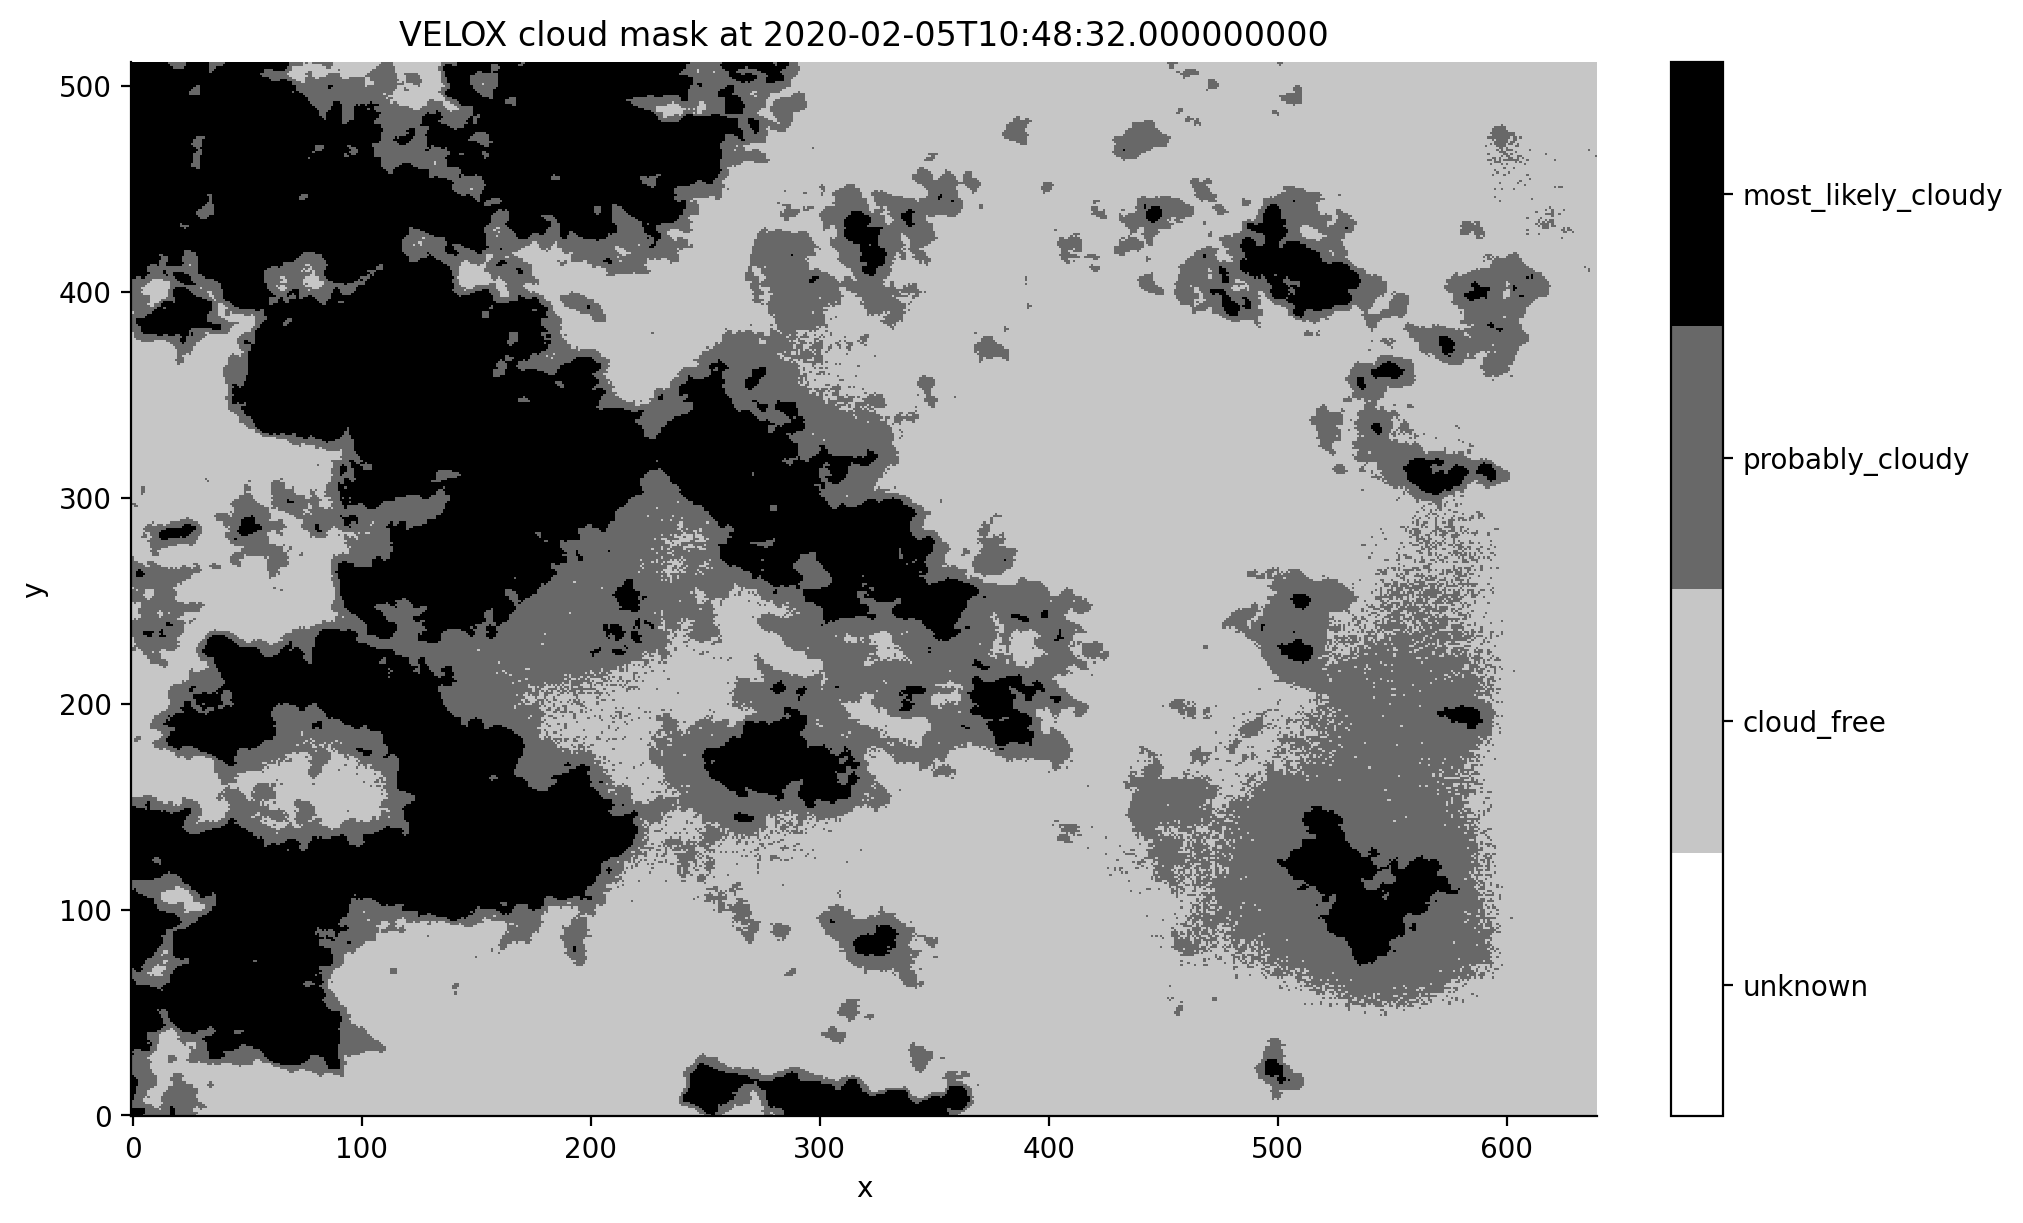

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("./mplstyle/book")

fig, ax = plt.subplots()

cax = ds_sel.plot(ax=ax,
                  cmap=plt.get_cmap('Greys', lut=4),
                  vmin=-1.5, vmax=2.5,
                  add_colorbar=False
                  )
cbar = fig.colorbar(cax, ticks=ds.cloud_mask.flag_values)
cbar.ax.set_yticklabels(ds.cloud_mask.flag_meanings.split(" "));

ax.set_title(f"VELOX cloud mask at {sonde_dt}");

What are the image cloud fraction lower and upper bounds?

In [12]:
cfmin = ds.CF_min.sel(time=sonde_dt, method="nearest").values
cfmax = ds.CF_max.sel(time=sonde_dt, method="nearest").values
print(f"Image minimum cloud fraction (most likely cloudy): {cfmin:.2f}")
print(f"Image maximum cloud fraction (most likely and probably cloudy) :{cfmax:.2f}")

Image minimum cloud fraction (most likely cloudy): 0.24
Image maximum cloud fraction (most likely and probably cloudy) :0.47


## Cloud fraction time series from the second circle on February 5

We also want to show a time series of cloud fraction and use the segment ID from the second circle to extract and save the segment information to the variable `seg`. We can later use the segments start and end times to select the data in time.

In [13]:
seg = segments_by_segment_id[second_circle_Feb05]

The dataset variable `CF_min` provides a lower bound to cloud fraction estimates based on the cloud mask flag `most_likely_cloudy`, while `CF_max` provides an upper bound by including the uncertain pixels labeled `probably cloudy`.

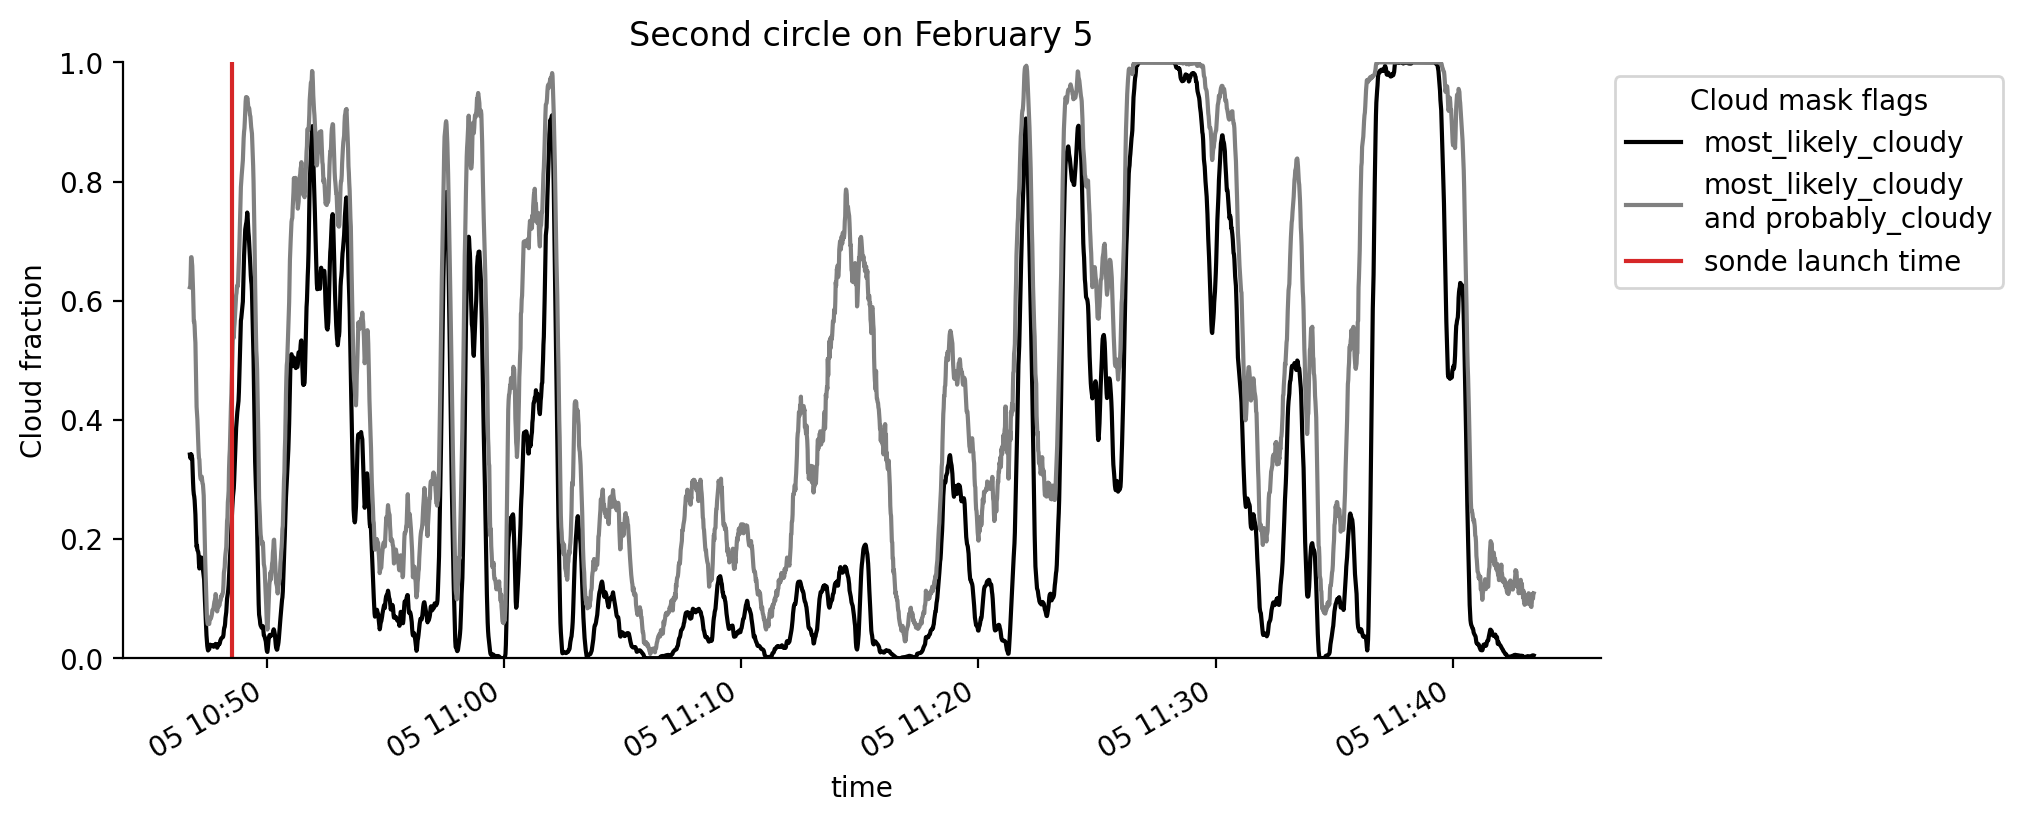

In [14]:
selection = ds.sel(time=slice(seg["start"], seg["end"]))

with plt.style.context("mplstyle/wide"):
    fig, ax = plt.subplots()
    selection.CF_min.plot(color="k", label="most_likely_cloudy")
    selection.CF_max.plot(color="grey", label="most_likely_cloudy\nand probably_cloudy")
    ax.axvline(sonde_dt, color="C3", label="sonde launch time")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Cloud fraction")
    ax.set_title("Second circle on February 5")
    ax.legend(title="Cloud mask flags", bbox_to_anchor=(1,1), loc="upper left");